In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


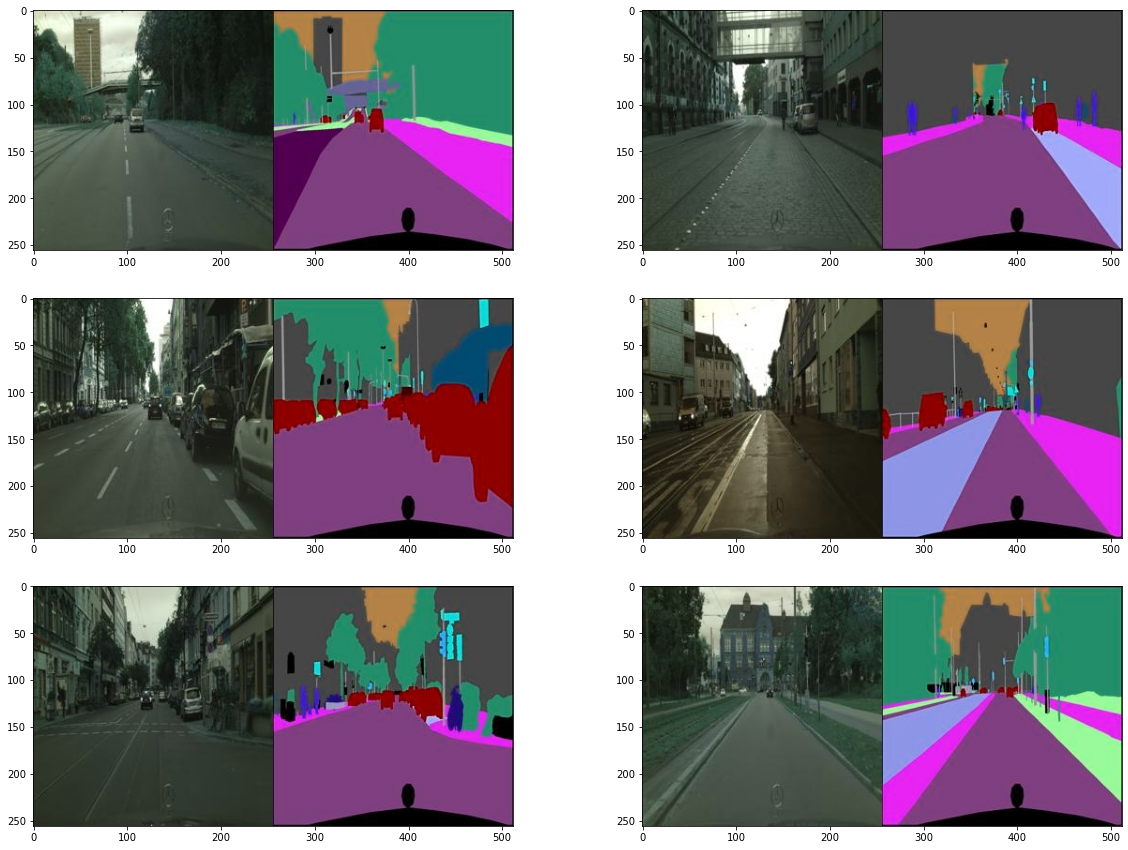

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


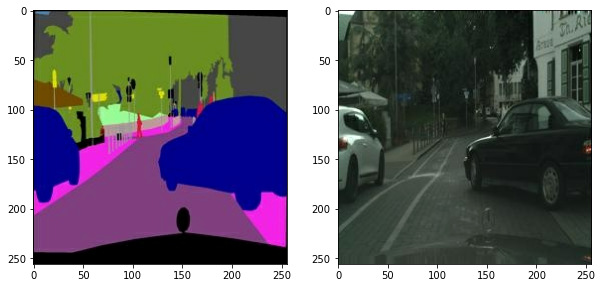

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Augmentation은 Rotation만 적용.
 - Padding을 하게 되면 흰색의 빈 공간이 생기는데, 그 공간은 정보가 없으므로 쓸모없는 데이터이다.

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    #_pad = tf.constant([[30,30],[30,30],[0,0]])
    #if tf.random.uniform(()) < .5:
    #    padded = tf.pad(stacked, _pad, "REFLECT")
    #else:
    #    padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    #out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(stacked)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

Text(0.5, 1.0, 'Image 3')

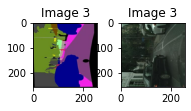

In [6]:
img_n = 3
augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
plt.subplot(3,4,i)
plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
plt.subplot(3,4,i+1); 
plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")


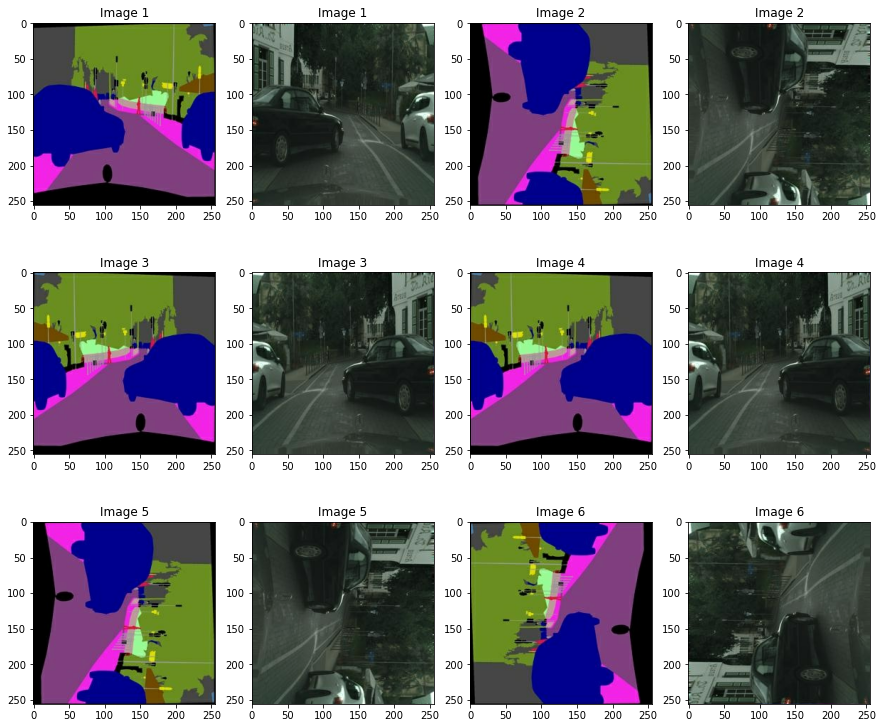

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

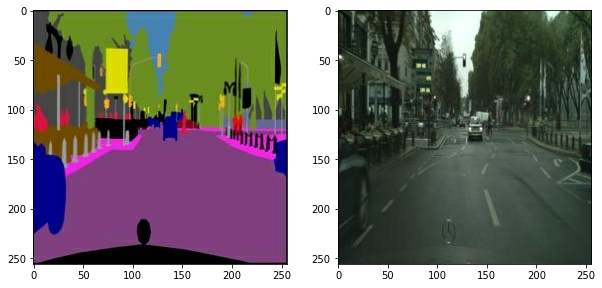

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

In [13]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

In [14]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]  

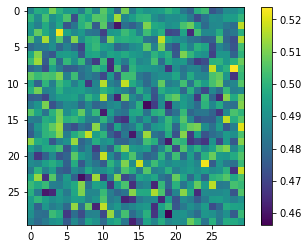

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [26]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9408                     
L1_loss:0.3445                     
Discriminator_loss:1.2114

EPOCH[1] - STEP[20]                     
Generator_loss:0.9873                     
L1_loss:0.2461                     
Discriminator_loss:1.2887

EPOCH[1] - STEP[30]                     
Generator_loss:0.7446                     
L1_loss:0.1794                     
Discriminator_loss:1.3299

EPOCH[1] - STEP[40]                     
Generator_loss:0.8885                     
L1_loss:0.2064                     
Discriminator_loss:1.1790

EPOCH[1] - STEP[50]                     
Generator_loss:0.8877                     
L1_loss:0.1988                     
Discriminator_loss:1.2716

EPOCH[1] - STEP[60]                     
Generator_loss:0.9943                     
L1_loss:0.1488                     
Discriminator_loss:1.0763

EPOCH[1] - STEP[70]                     
Generator_loss:1.0050                     
L1_loss:0.1953                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.1936                     
L1_loss:0.1939                     
Discriminator_loss:0.6175

EPOCH[3] - STEP[80]                     
Generator_loss:1.8559                     
L1_loss:0.2045                     
Discriminator_loss:0.7179

EPOCH[3] - STEP[90]                     
Generator_loss:1.0756                     
L1_loss:0.1601                     
Discriminator_loss:0.8155

EPOCH[3] - STEP[100]                     
Generator_loss:0.7311                     
L1_loss:0.2048                     
Discriminator_loss:0.9739

EPOCH[3] - STEP[110]                     
Generator_loss:1.0668                     
L1_loss:0.1767                     
Discriminator_loss:0.8943

EPOCH[3] - STEP[120]                     
Generator_loss:2.4603                     
L1_loss:0.2174                     
Discriminator_loss:0.2126

EPOCH[3] - STEP[130]                     
Generator_loss:1.9635                     
L1_loss:0.1911                

EPOCH[5] - STEP[130]                     
Generator_loss:0.3623                     
L1_loss:0.1674                     
Discriminator_loss:1.4718

EPOCH[5] - STEP[140]                     
Generator_loss:1.4385                     
L1_loss:0.1682                     
Discriminator_loss:0.9419

EPOCH[5] - STEP[150]                     
Generator_loss:1.8920                     
L1_loss:0.1719                     
Discriminator_loss:0.3223

EPOCH[5] - STEP[160]                     
Generator_loss:0.4192                     
L1_loss:0.1746                     
Discriminator_loss:1.7072

EPOCH[5] - STEP[170]                     
Generator_loss:1.0136                     
L1_loss:0.1893                     
Discriminator_loss:0.7664

EPOCH[5] - STEP[180]                     
Generator_loss:1.6393                     
L1_loss:0.2263                     
Discriminator_loss:0.3813

EPOCH[5] - STEP[190]                     
Generator_loss:1.4289                     
L1_loss:0.2100             

EPOCH[7] - STEP[190]                     
Generator_loss:1.6897                     
L1_loss:0.1652                     
Discriminator_loss:0.9484

EPOCH[7] - STEP[200]                     
Generator_loss:0.4038                     
L1_loss:0.1661                     
Discriminator_loss:1.5402

EPOCH[7] - STEP[210]                     
Generator_loss:0.9547                     
L1_loss:0.1967                     
Discriminator_loss:0.6214

EPOCH[7] - STEP[220]                     
Generator_loss:1.1669                     
L1_loss:0.2024                     
Discriminator_loss:1.2423

EPOCH[7] - STEP[230]                     
Generator_loss:2.9352                     
L1_loss:0.1966                     
Discriminator_loss:1.1435

EPOCH[7] - STEP[240]                     
Generator_loss:1.7732                     
L1_loss:0.2074                     
Discriminator_loss:0.5013

EPOCH[7] - STEP[250]                     
Generator_loss:1.5256                     
L1_loss:0.1616             

EPOCH[9] - STEP[250]                     
Generator_loss:0.7457                     
L1_loss:0.2064                     
Discriminator_loss:0.9620

EPOCH[10] - STEP[10]                     
Generator_loss:0.7513                     
L1_loss:0.2135                     
Discriminator_loss:0.8749

EPOCH[10] - STEP[20]                     
Generator_loss:1.9106                     
L1_loss:0.2204                     
Discriminator_loss:0.2711

EPOCH[10] - STEP[30]                     
Generator_loss:0.3845                     
L1_loss:0.1738                     
Discriminator_loss:1.6495

EPOCH[10] - STEP[40]                     
Generator_loss:0.2645                     
L1_loss:0.1760                     
Discriminator_loss:1.7651

EPOCH[10] - STEP[50]                     
Generator_loss:2.3729                     
L1_loss:0.1812                     
Discriminator_loss:1.1595

EPOCH[10] - STEP[60]                     
Generator_loss:1.3911                     
L1_loss:0.1896             

EPOCH[12] - STEP[60]                     
Generator_loss:1.5092                     
L1_loss:0.1739                     
Discriminator_loss:0.6149

EPOCH[12] - STEP[70]                     
Generator_loss:1.2836                     
L1_loss:0.1818                     
Discriminator_loss:0.7997

EPOCH[12] - STEP[80]                     
Generator_loss:1.5828                     
L1_loss:0.1674                     
Discriminator_loss:0.4525

EPOCH[12] - STEP[90]                     
Generator_loss:0.8050                     
L1_loss:0.1824                     
Discriminator_loss:0.8150

EPOCH[12] - STEP[100]                     
Generator_loss:2.7657                     
L1_loss:0.1448                     
Discriminator_loss:0.8963

EPOCH[12] - STEP[110]                     
Generator_loss:1.8489                     
L1_loss:0.1914                     
Discriminator_loss:0.7598

EPOCH[12] - STEP[120]                     
Generator_loss:1.9024                     
L1_loss:0.1726          

EPOCH[14] - STEP[120]                     
Generator_loss:1.9822                     
L1_loss:0.1794                     
Discriminator_loss:0.8346

EPOCH[14] - STEP[130]                     
Generator_loss:0.4581                     
L1_loss:0.1779                     
Discriminator_loss:1.2726

EPOCH[14] - STEP[140]                     
Generator_loss:1.5515                     
L1_loss:0.1811                     
Discriminator_loss:1.3877

EPOCH[14] - STEP[150]                     
Generator_loss:1.3103                     
L1_loss:0.1969                     
Discriminator_loss:0.4739

EPOCH[14] - STEP[160]                     
Generator_loss:2.0255                     
L1_loss:0.1649                     
Discriminator_loss:0.6212

EPOCH[14] - STEP[170]                     
Generator_loss:0.9489                     
L1_loss:0.2129                     
Discriminator_loss:0.6049

EPOCH[14] - STEP[180]                     
Generator_loss:2.8163                     
L1_loss:0.1936      

EPOCH[16] - STEP[180]                     
Generator_loss:2.2179                     
L1_loss:0.1565                     
Discriminator_loss:1.0109

EPOCH[16] - STEP[190]                     
Generator_loss:1.4058                     
L1_loss:0.1607                     
Discriminator_loss:0.4798

EPOCH[16] - STEP[200]                     
Generator_loss:1.9592                     
L1_loss:0.1836                     
Discriminator_loss:1.5334

EPOCH[16] - STEP[210]                     
Generator_loss:0.5707                     
L1_loss:0.1792                     
Discriminator_loss:1.5568

EPOCH[16] - STEP[220]                     
Generator_loss:1.0979                     
L1_loss:0.1857                     
Discriminator_loss:0.5451

EPOCH[16] - STEP[230]                     
Generator_loss:1.8234                     
L1_loss:0.2049                     
Discriminator_loss:0.3139

EPOCH[16] - STEP[240]                     
Generator_loss:0.8040                     
L1_loss:0.1858      

EPOCH[18] - STEP[240]                     
Generator_loss:0.6411                     
L1_loss:0.1683                     
Discriminator_loss:1.1067

EPOCH[18] - STEP[250]                     
Generator_loss:1.1402                     
L1_loss:0.1949                     
Discriminator_loss:0.5660

EPOCH[19] - STEP[10]                     
Generator_loss:1.4376                     
L1_loss:0.1735                     
Discriminator_loss:0.4495

EPOCH[19] - STEP[20]                     
Generator_loss:1.3377                     
L1_loss:0.1869                     
Discriminator_loss:0.4399

EPOCH[19] - STEP[30]                     
Generator_loss:0.9871                     
L1_loss:0.2261                     
Discriminator_loss:0.5355

EPOCH[19] - STEP[40]                     
Generator_loss:1.2324                     
L1_loss:0.1687                     
Discriminator_loss:1.3294

EPOCH[19] - STEP[50]                     
Generator_loss:1.3565                     
L1_loss:0.1895           

EPOCH[21] - STEP[50]                     
Generator_loss:1.8784                     
L1_loss:0.2402                     
Discriminator_loss:0.4083

EPOCH[21] - STEP[60]                     
Generator_loss:2.0876                     
L1_loss:0.1694                     
Discriminator_loss:1.4669

EPOCH[21] - STEP[70]                     
Generator_loss:0.6317                     
L1_loss:0.1701                     
Discriminator_loss:0.9379

EPOCH[21] - STEP[80]                     
Generator_loss:1.4627                     
L1_loss:0.1856                     
Discriminator_loss:1.2514

EPOCH[21] - STEP[90]                     
Generator_loss:1.1168                     
L1_loss:0.1659                     
Discriminator_loss:1.1630

EPOCH[21] - STEP[100]                     
Generator_loss:0.8506                     
L1_loss:0.1607                     
Discriminator_loss:0.8964

EPOCH[21] - STEP[110]                     
Generator_loss:1.9020                     
L1_loss:0.2081           

EPOCH[23] - STEP[110]                     
Generator_loss:0.7508                     
L1_loss:0.1975                     
Discriminator_loss:0.7559

EPOCH[23] - STEP[120]                     
Generator_loss:0.6257                     
L1_loss:0.1527                     
Discriminator_loss:1.4492

EPOCH[23] - STEP[130]                     
Generator_loss:0.8723                     
L1_loss:0.1743                     
Discriminator_loss:1.4618

EPOCH[23] - STEP[140]                     
Generator_loss:1.3873                     
L1_loss:0.1523                     
Discriminator_loss:1.4942

EPOCH[23] - STEP[150]                     
Generator_loss:2.3100                     
L1_loss:0.1496                     
Discriminator_loss:2.4595

EPOCH[23] - STEP[160]                     
Generator_loss:2.5828                     
L1_loss:0.1945                     
Discriminator_loss:0.1832

EPOCH[23] - STEP[170]                     
Generator_loss:1.0646                     
L1_loss:0.2078      

EPOCH[25] - STEP[170]                     
Generator_loss:1.3500                     
L1_loss:0.1555                     
Discriminator_loss:1.2432

EPOCH[25] - STEP[180]                     
Generator_loss:1.0913                     
L1_loss:0.1754                     
Discriminator_loss:0.7585

EPOCH[25] - STEP[190]                     
Generator_loss:0.8144                     
L1_loss:0.1645                     
Discriminator_loss:0.7177

EPOCH[25] - STEP[200]                     
Generator_loss:1.5938                     
L1_loss:0.1751                     
Discriminator_loss:1.1696

EPOCH[25] - STEP[210]                     
Generator_loss:1.8900                     
L1_loss:0.1820                     
Discriminator_loss:1.3700

EPOCH[25] - STEP[220]                     
Generator_loss:0.9805                     
L1_loss:0.2081                     
Discriminator_loss:0.5607

EPOCH[25] - STEP[230]                     
Generator_loss:1.5267                     
L1_loss:0.1942      

EPOCH[27] - STEP[230]                     
Generator_loss:0.8831                     
L1_loss:0.1903                     
Discriminator_loss:0.7595

EPOCH[27] - STEP[240]                     
Generator_loss:1.1028                     
L1_loss:0.1861                     
Discriminator_loss:0.8776

EPOCH[27] - STEP[250]                     
Generator_loss:1.0143                     
L1_loss:0.1852                     
Discriminator_loss:0.7653

EPOCH[28] - STEP[10]                     
Generator_loss:1.5041                     
L1_loss:0.1675                     
Discriminator_loss:0.8486

EPOCH[28] - STEP[20]                     
Generator_loss:1.4812                     
L1_loss:0.1771                     
Discriminator_loss:0.5333

EPOCH[28] - STEP[30]                     
Generator_loss:1.1426                     
L1_loss:0.2071                     
Discriminator_loss:0.4791

EPOCH[28] - STEP[40]                     
Generator_loss:1.6486                     
L1_loss:0.1923          

EPOCH[30] - STEP[40]                     
Generator_loss:1.4383                     
L1_loss:0.1935                     
Discriminator_loss:0.3825

EPOCH[30] - STEP[50]                     
Generator_loss:0.9779                     
L1_loss:0.2068                     
Discriminator_loss:0.5776

EPOCH[30] - STEP[60]                     
Generator_loss:1.8896                     
L1_loss:0.1734                     
Discriminator_loss:0.4802

EPOCH[30] - STEP[70]                     
Generator_loss:2.0119                     
L1_loss:0.1530                     
Discriminator_loss:1.5843

EPOCH[30] - STEP[80]                     
Generator_loss:1.2170                     
L1_loss:0.1598                     
Discriminator_loss:0.6163

EPOCH[30] - STEP[90]                     
Generator_loss:1.0794                     
L1_loss:0.1635                     
Discriminator_loss:0.6707

EPOCH[30] - STEP[100]                     
Generator_loss:1.7300                     
L1_loss:0.1816            

EPOCH[32] - STEP[100]                     
Generator_loss:1.5290                     
L1_loss:0.1862                     
Discriminator_loss:0.4625

EPOCH[32] - STEP[110]                     
Generator_loss:1.8236                     
L1_loss:0.1605                     
Discriminator_loss:0.9795

EPOCH[32] - STEP[120]                     
Generator_loss:1.8848                     
L1_loss:0.1733                     
Discriminator_loss:1.0420

EPOCH[32] - STEP[130]                     
Generator_loss:2.0669                     
L1_loss:0.1746                     
Discriminator_loss:0.9396

EPOCH[32] - STEP[140]                     
Generator_loss:2.3801                     
L1_loss:0.1515                     
Discriminator_loss:1.0347

EPOCH[32] - STEP[150]                     
Generator_loss:0.9931                     
L1_loss:0.1622                     
Discriminator_loss:0.7461

EPOCH[32] - STEP[160]                     
Generator_loss:1.7642                     
L1_loss:0.1556      

EPOCH[34] - STEP[160]                     
Generator_loss:1.0176                     
L1_loss:0.1839                     
Discriminator_loss:0.7725

EPOCH[34] - STEP[170]                     
Generator_loss:1.9302                     
L1_loss:0.1663                     
Discriminator_loss:0.7196

EPOCH[34] - STEP[180]                     
Generator_loss:1.2339                     
L1_loss:0.1732                     
Discriminator_loss:1.1589

EPOCH[34] - STEP[190]                     
Generator_loss:2.5397                     
L1_loss:0.1656                     
Discriminator_loss:2.0045

EPOCH[34] - STEP[200]                     
Generator_loss:2.1505                     
L1_loss:0.1692                     
Discriminator_loss:1.3456

EPOCH[34] - STEP[210]                     
Generator_loss:1.1320                     
L1_loss:0.1954                     
Discriminator_loss:0.5452

EPOCH[34] - STEP[220]                     
Generator_loss:2.3739                     
L1_loss:0.1776      

EPOCH[36] - STEP[220]                     
Generator_loss:2.4663                     
L1_loss:0.1925                     
Discriminator_loss:0.9460

EPOCH[36] - STEP[230]                     
Generator_loss:1.4181                     
L1_loss:0.1692                     
Discriminator_loss:0.5784

EPOCH[36] - STEP[240]                     
Generator_loss:0.7925                     
L1_loss:0.1744                     
Discriminator_loss:0.7707

EPOCH[36] - STEP[250]                     
Generator_loss:1.2058                     
L1_loss:0.1795                     
Discriminator_loss:0.7448

EPOCH[37] - STEP[10]                     
Generator_loss:2.2187                     
L1_loss:0.1995                     
Discriminator_loss:0.3018

EPOCH[37] - STEP[20]                     
Generator_loss:0.7842                     
L1_loss:0.1883                     
Discriminator_loss:0.7136

EPOCH[37] - STEP[30]                     
Generator_loss:1.6960                     
L1_loss:0.1899         

EPOCH[39] - STEP[30]                     
Generator_loss:1.0275                     
L1_loss:0.1844                     
Discriminator_loss:0.5647

EPOCH[39] - STEP[40]                     
Generator_loss:1.1190                     
L1_loss:0.1574                     
Discriminator_loss:1.2117

EPOCH[39] - STEP[50]                     
Generator_loss:1.7342                     
L1_loss:0.1683                     
Discriminator_loss:1.3704

EPOCH[39] - STEP[60]                     
Generator_loss:1.4685                     
L1_loss:0.1784                     
Discriminator_loss:0.7516

EPOCH[39] - STEP[70]                     
Generator_loss:1.6450                     
L1_loss:0.1697                     
Discriminator_loss:1.0795

EPOCH[39] - STEP[80]                     
Generator_loss:1.0575                     
L1_loss:0.2138                     
Discriminator_loss:0.5134

EPOCH[39] - STEP[90]                     
Generator_loss:2.4653                     
L1_loss:0.1824             

EPOCH[41] - STEP[90]                     
Generator_loss:1.5143                     
L1_loss:0.1655                     
Discriminator_loss:0.7748

EPOCH[41] - STEP[100]                     
Generator_loss:0.9738                     
L1_loss:0.2001                     
Discriminator_loss:0.5722

EPOCH[41] - STEP[110]                     
Generator_loss:1.3119                     
L1_loss:0.1572                     
Discriminator_loss:0.9129

EPOCH[41] - STEP[120]                     
Generator_loss:1.4256                     
L1_loss:0.1536                     
Discriminator_loss:1.1656

EPOCH[41] - STEP[130]                     
Generator_loss:1.4066                     
L1_loss:0.1801                     
Discriminator_loss:0.5673

EPOCH[41] - STEP[140]                     
Generator_loss:1.4501                     
L1_loss:0.1657                     
Discriminator_loss:1.3066

EPOCH[41] - STEP[150]                     
Generator_loss:1.3098                     
L1_loss:0.1660       

EPOCH[43] - STEP[150]                     
Generator_loss:1.0407                     
L1_loss:0.1362                     
Discriminator_loss:1.3458

EPOCH[43] - STEP[160]                     
Generator_loss:1.9567                     
L1_loss:0.1778                     
Discriminator_loss:0.2920

EPOCH[43] - STEP[170]                     
Generator_loss:1.5433                     
L1_loss:0.1602                     
Discriminator_loss:0.8047

EPOCH[43] - STEP[180]                     
Generator_loss:1.4848                     
L1_loss:0.1657                     
Discriminator_loss:0.3457

EPOCH[43] - STEP[190]                     
Generator_loss:1.5587                     
L1_loss:0.1543                     
Discriminator_loss:0.9833

EPOCH[43] - STEP[200]                     
Generator_loss:1.9211                     
L1_loss:0.1890                     
Discriminator_loss:0.6171

EPOCH[43] - STEP[210]                     
Generator_loss:0.9431                     
L1_loss:0.1997      

EPOCH[45] - STEP[210]                     
Generator_loss:0.9169                     
L1_loss:0.1846                     
Discriminator_loss:0.8487

EPOCH[45] - STEP[220]                     
Generator_loss:1.2147                     
L1_loss:0.1625                     
Discriminator_loss:2.2324

EPOCH[45] - STEP[230]                     
Generator_loss:1.3542                     
L1_loss:0.1734                     
Discriminator_loss:0.4847

EPOCH[45] - STEP[240]                     
Generator_loss:1.2816                     
L1_loss:0.1704                     
Discriminator_loss:1.5593

EPOCH[45] - STEP[250]                     
Generator_loss:2.0676                     
L1_loss:0.1711                     
Discriminator_loss:0.8493

EPOCH[46] - STEP[10]                     
Generator_loss:1.3892                     
L1_loss:0.1631                     
Discriminator_loss:0.6789

EPOCH[46] - STEP[20]                     
Generator_loss:1.4464                     
L1_loss:0.2038        

EPOCH[48] - STEP[20]                     
Generator_loss:0.5110                     
L1_loss:0.1871                     
Discriminator_loss:1.1310

EPOCH[48] - STEP[30]                     
Generator_loss:1.5612                     
L1_loss:0.1873                     
Discriminator_loss:0.3400

EPOCH[48] - STEP[40]                     
Generator_loss:0.8842                     
L1_loss:0.1486                     
Discriminator_loss:0.9380

EPOCH[48] - STEP[50]                     
Generator_loss:0.8192                     
L1_loss:0.1693                     
Discriminator_loss:0.7909

EPOCH[48] - STEP[60]                     
Generator_loss:2.5301                     
L1_loss:0.1562                     
Discriminator_loss:0.9416

EPOCH[48] - STEP[70]                     
Generator_loss:1.8083                     
L1_loss:0.1653                     
Discriminator_loss:0.7548

EPOCH[48] - STEP[80]                     
Generator_loss:1.4566                     
L1_loss:0.1758             

EPOCH[50] - STEP[80]                     
Generator_loss:1.3414                     
L1_loss:0.1806                     
Discriminator_loss:1.2974

EPOCH[50] - STEP[90]                     
Generator_loss:0.9186                     
L1_loss:0.1563                     
Discriminator_loss:1.0725

EPOCH[50] - STEP[100]                     
Generator_loss:1.3551                     
L1_loss:0.1729                     
Discriminator_loss:0.4071

EPOCH[50] - STEP[110]                     
Generator_loss:0.9933                     
L1_loss:0.1623                     
Discriminator_loss:1.0386

EPOCH[50] - STEP[120]                     
Generator_loss:1.3255                     
L1_loss:0.1720                     
Discriminator_loss:0.4946

EPOCH[50] - STEP[130]                     
Generator_loss:1.4069                     
L1_loss:0.1375                     
Discriminator_loss:1.0443

EPOCH[50] - STEP[140]                     
Generator_loss:1.5974                     
L1_loss:0.1745        

EPOCH[52] - STEP[140]                     
Generator_loss:1.5005                     
L1_loss:0.1903                     
Discriminator_loss:0.4750

EPOCH[52] - STEP[150]                     
Generator_loss:1.4043                     
L1_loss:0.1526                     
Discriminator_loss:0.6583

EPOCH[52] - STEP[160]                     
Generator_loss:1.3816                     
L1_loss:0.1666                     
Discriminator_loss:1.5207

EPOCH[52] - STEP[170]                     
Generator_loss:1.1390                     
L1_loss:0.1759                     
Discriminator_loss:0.9842

EPOCH[52] - STEP[180]                     
Generator_loss:2.8367                     
L1_loss:0.2015                     
Discriminator_loss:0.1731

EPOCH[52] - STEP[190]                     
Generator_loss:1.2051                     
L1_loss:0.1380                     
Discriminator_loss:1.5127

EPOCH[52] - STEP[200]                     
Generator_loss:1.1977                     
L1_loss:0.1517      

EPOCH[54] - STEP[200]                     
Generator_loss:1.8154                     
L1_loss:0.1636                     
Discriminator_loss:0.4731

EPOCH[54] - STEP[210]                     
Generator_loss:1.5225                     
L1_loss:0.1854                     
Discriminator_loss:0.3410

EPOCH[54] - STEP[220]                     
Generator_loss:1.7719                     
L1_loss:0.1519                     
Discriminator_loss:1.0931

EPOCH[54] - STEP[230]                     
Generator_loss:1.2650                     
L1_loss:0.1843                     
Discriminator_loss:0.7288

EPOCH[54] - STEP[240]                     
Generator_loss:0.8403                     
L1_loss:0.1795                     
Discriminator_loss:0.8463

EPOCH[54] - STEP[250]                     
Generator_loss:0.8432                     
L1_loss:0.1988                     
Discriminator_loss:0.7083

EPOCH[55] - STEP[10]                     
Generator_loss:1.2405                     
L1_loss:0.1649       

EPOCH[57] - STEP[10]                     
Generator_loss:0.9478                     
L1_loss:0.1452                     
Discriminator_loss:1.0597

EPOCH[57] - STEP[20]                     
Generator_loss:1.5516                     
L1_loss:0.1740                     
Discriminator_loss:0.3855

EPOCH[57] - STEP[30]                     
Generator_loss:0.3509                     
L1_loss:0.1549                     
Discriminator_loss:1.5810

EPOCH[57] - STEP[40]                     
Generator_loss:1.0680                     
L1_loss:0.1795                     
Discriminator_loss:0.9558

EPOCH[57] - STEP[50]                     
Generator_loss:1.6758                     
L1_loss:0.1495                     
Discriminator_loss:0.8170

EPOCH[57] - STEP[60]                     
Generator_loss:2.0823                     
L1_loss:0.1577                     
Discriminator_loss:0.3197

EPOCH[57] - STEP[70]                     
Generator_loss:1.4555                     
L1_loss:0.1596             

EPOCH[59] - STEP[70]                     
Generator_loss:0.2450                     
L1_loss:0.1601                     
Discriminator_loss:1.8839

EPOCH[59] - STEP[80]                     
Generator_loss:1.7895                     
L1_loss:0.1688                     
Discriminator_loss:0.7683

EPOCH[59] - STEP[90]                     
Generator_loss:0.6522                     
L1_loss:0.1523                     
Discriminator_loss:1.0651

EPOCH[59] - STEP[100]                     
Generator_loss:1.6691                     
L1_loss:0.1848                     
Discriminator_loss:0.3279

EPOCH[59] - STEP[110]                     
Generator_loss:0.8537                     
L1_loss:0.1607                     
Discriminator_loss:1.0526

EPOCH[59] - STEP[120]                     
Generator_loss:1.8644                     
L1_loss:0.1546                     
Discriminator_loss:0.4905

EPOCH[59] - STEP[130]                     
Generator_loss:0.6563                     
L1_loss:0.1772         

EPOCH[61] - STEP[130]                     
Generator_loss:1.0179                     
L1_loss:0.1869                     
Discriminator_loss:0.6103

EPOCH[61] - STEP[140]                     
Generator_loss:0.6046                     
L1_loss:0.1333                     
Discriminator_loss:1.0447

EPOCH[61] - STEP[150]                     
Generator_loss:1.4681                     
L1_loss:0.1425                     
Discriminator_loss:0.7667

EPOCH[61] - STEP[160]                     
Generator_loss:0.7075                     
L1_loss:0.1798                     
Discriminator_loss:0.8476

EPOCH[61] - STEP[170]                     
Generator_loss:1.2425                     
L1_loss:0.1450                     
Discriminator_loss:0.6933

EPOCH[61] - STEP[180]                     
Generator_loss:1.8981                     
L1_loss:0.1517                     
Discriminator_loss:0.6206

EPOCH[61] - STEP[190]                     
Generator_loss:1.5129                     
L1_loss:0.1819      

EPOCH[63] - STEP[190]                     
Generator_loss:1.1378                     
L1_loss:0.1795                     
Discriminator_loss:0.5423

EPOCH[63] - STEP[200]                     
Generator_loss:2.2726                     
L1_loss:0.1493                     
Discriminator_loss:0.6396

EPOCH[63] - STEP[210]                     
Generator_loss:1.5266                     
L1_loss:0.1717                     
Discriminator_loss:0.3647

EPOCH[63] - STEP[220]                     
Generator_loss:0.6924                     
L1_loss:0.1405                     
Discriminator_loss:1.3011

EPOCH[63] - STEP[230]                     
Generator_loss:1.9811                     
L1_loss:0.1768                     
Discriminator_loss:0.2518

EPOCH[63] - STEP[240]                     
Generator_loss:0.6311                     
L1_loss:0.1971                     
Discriminator_loss:0.9184

EPOCH[63] - STEP[250]                     
Generator_loss:1.0284                     
L1_loss:0.1703      

EPOCH[65] - STEP[250]                     
Generator_loss:1.6403                     
L1_loss:0.1474                     
Discriminator_loss:2.2011

EPOCH[66] - STEP[10]                     
Generator_loss:1.0499                     
L1_loss:0.1698                     
Discriminator_loss:0.6258

EPOCH[66] - STEP[20]                     
Generator_loss:0.5652                     
L1_loss:0.1665                     
Discriminator_loss:1.1565

EPOCH[66] - STEP[30]                     
Generator_loss:1.2270                     
L1_loss:0.1542                     
Discriminator_loss:0.5044

EPOCH[66] - STEP[40]                     
Generator_loss:1.6873                     
L1_loss:0.1652                     
Discriminator_loss:0.8189

EPOCH[66] - STEP[50]                     
Generator_loss:1.0658                     
L1_loss:0.1652                     
Discriminator_loss:1.1278

EPOCH[66] - STEP[60]                     
Generator_loss:1.5996                     
L1_loss:0.1657            

EPOCH[68] - STEP[60]                     
Generator_loss:1.4846                     
L1_loss:0.1619                     
Discriminator_loss:0.6875

EPOCH[68] - STEP[70]                     
Generator_loss:1.4802                     
L1_loss:0.1551                     
Discriminator_loss:0.8570

EPOCH[68] - STEP[80]                     
Generator_loss:1.2239                     
L1_loss:0.1492                     
Discriminator_loss:0.5461

EPOCH[68] - STEP[90]                     
Generator_loss:2.0299                     
L1_loss:0.1599                     
Discriminator_loss:0.7903

EPOCH[68] - STEP[100]                     
Generator_loss:0.9917                     
L1_loss:0.1800                     
Discriminator_loss:0.7019

EPOCH[68] - STEP[110]                     
Generator_loss:0.8287                     
L1_loss:0.2040                     
Discriminator_loss:1.5385

EPOCH[68] - STEP[120]                     
Generator_loss:0.9415                     
L1_loss:0.1365          

EPOCH[70] - STEP[120]                     
Generator_loss:0.9446                     
L1_loss:0.1850                     
Discriminator_loss:0.6070

EPOCH[70] - STEP[130]                     
Generator_loss:0.4747                     
L1_loss:0.1704                     
Discriminator_loss:1.4353

EPOCH[70] - STEP[140]                     
Generator_loss:0.6564                     
L1_loss:0.1825                     
Discriminator_loss:0.8447

EPOCH[70] - STEP[150]                     
Generator_loss:0.7732                     
L1_loss:0.1802                     
Discriminator_loss:0.9300

EPOCH[70] - STEP[160]                     
Generator_loss:2.0355                     
L1_loss:0.1583                     
Discriminator_loss:0.3207

EPOCH[70] - STEP[170]                     
Generator_loss:0.9797                     
L1_loss:0.1795                     
Discriminator_loss:0.5802

EPOCH[70] - STEP[180]                     
Generator_loss:0.7366                     
L1_loss:0.1888      

EPOCH[72] - STEP[180]                     
Generator_loss:1.7411                     
L1_loss:0.1856                     
Discriminator_loss:0.6150

EPOCH[72] - STEP[190]                     
Generator_loss:2.0978                     
L1_loss:0.1851                     
Discriminator_loss:0.7006

EPOCH[72] - STEP[200]                     
Generator_loss:0.8622                     
L1_loss:0.1595                     
Discriminator_loss:0.7674

EPOCH[72] - STEP[210]                     
Generator_loss:0.8475                     
L1_loss:0.1419                     
Discriminator_loss:1.8863

EPOCH[72] - STEP[220]                     
Generator_loss:1.2000                     
L1_loss:0.1835                     
Discriminator_loss:0.6003

EPOCH[72] - STEP[230]                     
Generator_loss:1.6884                     
L1_loss:0.1675                     
Discriminator_loss:0.7367

EPOCH[72] - STEP[240]                     
Generator_loss:1.0295                     
L1_loss:0.1583      

EPOCH[74] - STEP[240]                     
Generator_loss:1.0284                     
L1_loss:0.1666                     
Discriminator_loss:0.7051

EPOCH[74] - STEP[250]                     
Generator_loss:1.1526                     
L1_loss:0.1850                     
Discriminator_loss:0.4871

EPOCH[75] - STEP[10]                     
Generator_loss:0.9406                     
L1_loss:0.1679                     
Discriminator_loss:0.6948

EPOCH[75] - STEP[20]                     
Generator_loss:1.9562                     
L1_loss:0.1569                     
Discriminator_loss:0.4335

EPOCH[75] - STEP[30]                     
Generator_loss:1.7408                     
L1_loss:0.1487                     
Discriminator_loss:1.5583

EPOCH[75] - STEP[40]                     
Generator_loss:0.6297                     
L1_loss:0.1353                     
Discriminator_loss:1.2700

EPOCH[75] - STEP[50]                     
Generator_loss:1.7541                     
L1_loss:0.1589           

EPOCH[77] - STEP[50]                     
Generator_loss:1.8761                     
L1_loss:0.1714                     
Discriminator_loss:0.3071

EPOCH[77] - STEP[60]                     
Generator_loss:0.4310                     
L1_loss:0.1632                     
Discriminator_loss:2.2754

EPOCH[77] - STEP[70]                     
Generator_loss:0.9392                     
L1_loss:0.1421                     
Discriminator_loss:0.9015

EPOCH[77] - STEP[80]                     
Generator_loss:2.0651                     
L1_loss:0.1646                     
Discriminator_loss:0.3803

EPOCH[77] - STEP[90]                     
Generator_loss:1.0252                     
L1_loss:0.1727                     
Discriminator_loss:0.5655

EPOCH[77] - STEP[100]                     
Generator_loss:1.0097                     
L1_loss:0.1637                     
Discriminator_loss:0.8011

EPOCH[77] - STEP[110]                     
Generator_loss:0.7315                     
L1_loss:0.1594           

EPOCH[79] - STEP[110]                     
Generator_loss:1.6103                     
L1_loss:0.1486                     
Discriminator_loss:0.9642

EPOCH[79] - STEP[120]                     
Generator_loss:0.4978                     
L1_loss:0.1573                     
Discriminator_loss:2.1269

EPOCH[79] - STEP[130]                     
Generator_loss:0.8865                     
L1_loss:0.1614                     
Discriminator_loss:0.7396

EPOCH[79] - STEP[140]                     
Generator_loss:1.7667                     
L1_loss:0.1631                     
Discriminator_loss:0.3727

EPOCH[79] - STEP[150]                     
Generator_loss:1.1216                     
L1_loss:0.1737                     
Discriminator_loss:0.4939

EPOCH[79] - STEP[160]                     
Generator_loss:0.8178                     
L1_loss:0.1407                     
Discriminator_loss:0.9131

EPOCH[79] - STEP[170]                     
Generator_loss:1.3945                     
L1_loss:0.1639      

EPOCH[81] - STEP[170]                     
Generator_loss:1.7679                     
L1_loss:0.1536                     
Discriminator_loss:1.0758

EPOCH[81] - STEP[180]                     
Generator_loss:0.8681                     
L1_loss:0.1671                     
Discriminator_loss:0.8337

EPOCH[81] - STEP[190]                     
Generator_loss:1.6501                     
L1_loss:0.1638                     
Discriminator_loss:1.1230

EPOCH[81] - STEP[200]                     
Generator_loss:2.1050                     
L1_loss:0.1587                     
Discriminator_loss:0.8617

EPOCH[81] - STEP[210]                     
Generator_loss:1.7946                     
L1_loss:0.1468                     
Discriminator_loss:0.7823

EPOCH[81] - STEP[220]                     
Generator_loss:1.4981                     
L1_loss:0.1384                     
Discriminator_loss:0.7874

EPOCH[81] - STEP[230]                     
Generator_loss:1.2621                     
L1_loss:0.1655      

EPOCH[83] - STEP[230]                     
Generator_loss:1.4380                     
L1_loss:0.1403                     
Discriminator_loss:0.9367

EPOCH[83] - STEP[240]                     
Generator_loss:1.3887                     
L1_loss:0.1801                     
Discriminator_loss:0.3951

EPOCH[83] - STEP[250]                     
Generator_loss:0.7789                     
L1_loss:0.1460                     
Discriminator_loss:1.3998

EPOCH[84] - STEP[10]                     
Generator_loss:1.0057                     
L1_loss:0.1372                     
Discriminator_loss:1.2430

EPOCH[84] - STEP[20]                     
Generator_loss:0.6737                     
L1_loss:0.1413                     
Discriminator_loss:1.4581

EPOCH[84] - STEP[30]                     
Generator_loss:1.8950                     
L1_loss:0.1551                     
Discriminator_loss:1.1350

EPOCH[84] - STEP[40]                     
Generator_loss:2.2257                     
L1_loss:0.1248          

EPOCH[86] - STEP[40]                     
Generator_loss:0.9648                     
L1_loss:0.1507                     
Discriminator_loss:0.6862

EPOCH[86] - STEP[50]                     
Generator_loss:1.8417                     
L1_loss:0.1417                     
Discriminator_loss:1.4000

EPOCH[86] - STEP[60]                     
Generator_loss:1.0796                     
L1_loss:0.1312                     
Discriminator_loss:1.4612

EPOCH[86] - STEP[70]                     
Generator_loss:1.0711                     
L1_loss:0.1654                     
Discriminator_loss:0.8265

EPOCH[86] - STEP[80]                     
Generator_loss:0.1405                     
L1_loss:0.1632                     
Discriminator_loss:2.3638

EPOCH[86] - STEP[90]                     
Generator_loss:0.9037                     
L1_loss:0.1601                     
Discriminator_loss:0.9083

EPOCH[86] - STEP[100]                     
Generator_loss:2.4621                     
L1_loss:0.1413            

EPOCH[88] - STEP[100]                     
Generator_loss:0.5574                     
L1_loss:0.1341                     
Discriminator_loss:1.5607

EPOCH[88] - STEP[110]                     
Generator_loss:0.4604                     
L1_loss:0.1469                     
Discriminator_loss:1.2734

EPOCH[88] - STEP[120]                     
Generator_loss:1.5301                     
L1_loss:0.1866                     
Discriminator_loss:0.3052

EPOCH[88] - STEP[130]                     
Generator_loss:1.9280                     
L1_loss:0.1279                     
Discriminator_loss:1.6348

EPOCH[88] - STEP[140]                     
Generator_loss:0.7453                     
L1_loss:0.1509                     
Discriminator_loss:0.8472

EPOCH[88] - STEP[150]                     
Generator_loss:0.9348                     
L1_loss:0.1705                     
Discriminator_loss:0.6004

EPOCH[88] - STEP[160]                     
Generator_loss:0.7924                     
L1_loss:0.1397      

EPOCH[90] - STEP[160]                     
Generator_loss:1.8104                     
L1_loss:0.1606                     
Discriminator_loss:0.7258

EPOCH[90] - STEP[170]                     
Generator_loss:0.3510                     
L1_loss:0.1909                     
Discriminator_loss:1.3933

EPOCH[90] - STEP[180]                     
Generator_loss:0.9134                     
L1_loss:0.1410                     
Discriminator_loss:0.9607

EPOCH[90] - STEP[190]                     
Generator_loss:0.4279                     
L1_loss:0.1611                     
Discriminator_loss:1.3554

EPOCH[90] - STEP[200]                     
Generator_loss:0.6611                     
L1_loss:0.1785                     
Discriminator_loss:0.9322

EPOCH[90] - STEP[210]                     
Generator_loss:2.4980                     
L1_loss:0.1422                     
Discriminator_loss:1.1576

EPOCH[90] - STEP[220]                     
Generator_loss:1.5744                     
L1_loss:0.1548      

EPOCH[92] - STEP[220]                     
Generator_loss:2.4388                     
L1_loss:0.1447                     
Discriminator_loss:1.8668

EPOCH[92] - STEP[230]                     
Generator_loss:2.0338                     
L1_loss:0.1262                     
Discriminator_loss:2.1192

EPOCH[92] - STEP[240]                     
Generator_loss:2.2817                     
L1_loss:0.1310                     
Discriminator_loss:1.5668

EPOCH[92] - STEP[250]                     
Generator_loss:0.7946                     
L1_loss:0.1467                     
Discriminator_loss:1.1908

EPOCH[93] - STEP[10]                     
Generator_loss:1.2688                     
L1_loss:0.1488                     
Discriminator_loss:0.5084

EPOCH[93] - STEP[20]                     
Generator_loss:1.5042                     
L1_loss:0.1501                     
Discriminator_loss:0.6853

EPOCH[93] - STEP[30]                     
Generator_loss:0.7837                     
L1_loss:0.1465         

EPOCH[95] - STEP[30]                     
Generator_loss:1.1261                     
L1_loss:0.1236                     
Discriminator_loss:1.3642

EPOCH[95] - STEP[40]                     
Generator_loss:2.0014                     
L1_loss:0.1486                     
Discriminator_loss:0.9510

EPOCH[95] - STEP[50]                     
Generator_loss:1.0538                     
L1_loss:0.1343                     
Discriminator_loss:1.2118

EPOCH[95] - STEP[60]                     
Generator_loss:1.1224                     
L1_loss:0.1500                     
Discriminator_loss:0.7886

EPOCH[95] - STEP[70]                     
Generator_loss:1.4600                     
L1_loss:0.1317                     
Discriminator_loss:0.8140

EPOCH[95] - STEP[80]                     
Generator_loss:1.1423                     
L1_loss:0.1540                     
Discriminator_loss:0.7911

EPOCH[95] - STEP[90]                     
Generator_loss:0.9249                     
L1_loss:0.1354             

EPOCH[97] - STEP[90]                     
Generator_loss:1.8832                     
L1_loss:0.1326                     
Discriminator_loss:1.1957

EPOCH[97] - STEP[100]                     
Generator_loss:1.0558                     
L1_loss:0.1629                     
Discriminator_loss:0.6778

EPOCH[97] - STEP[110]                     
Generator_loss:1.2493                     
L1_loss:0.1292                     
Discriminator_loss:1.3167

EPOCH[97] - STEP[120]                     
Generator_loss:0.6932                     
L1_loss:0.1553                     
Discriminator_loss:0.9291

EPOCH[97] - STEP[130]                     
Generator_loss:1.9793                     
L1_loss:0.1550                     
Discriminator_loss:0.3395

EPOCH[97] - STEP[140]                     
Generator_loss:0.7147                     
L1_loss:0.1456                     
Discriminator_loss:1.4981

EPOCH[97] - STEP[150]                     
Generator_loss:1.0716                     
L1_loss:0.1424       

EPOCH[99] - STEP[150]                     
Generator_loss:0.6256                     
L1_loss:0.1655                     
Discriminator_loss:1.0584

EPOCH[99] - STEP[160]                     
Generator_loss:0.3692                     
L1_loss:0.1671                     
Discriminator_loss:1.4702

EPOCH[99] - STEP[170]                     
Generator_loss:1.5782                     
L1_loss:0.1415                     
Discriminator_loss:0.5900

EPOCH[99] - STEP[180]                     
Generator_loss:1.0852                     
L1_loss:0.1542                     
Discriminator_loss:0.6578

EPOCH[99] - STEP[190]                     
Generator_loss:0.5657                     
L1_loss:0.1745                     
Discriminator_loss:0.9648

EPOCH[99] - STEP[200]                     
Generator_loss:1.7298                     
L1_loss:0.1216                     
Discriminator_loss:1.0177

EPOCH[99] - STEP[210]                     
Generator_loss:1.4196                     
L1_loss:0.1673      

EPOCH[101] - STEP[200]                     
Generator_loss:2.0368                     
L1_loss:0.1551                     
Discriminator_loss:1.4368

EPOCH[101] - STEP[210]                     
Generator_loss:1.8493                     
L1_loss:0.1555                     
Discriminator_loss:0.7861

EPOCH[101] - STEP[220]                     
Generator_loss:0.9384                     
L1_loss:0.1499                     
Discriminator_loss:0.9081

EPOCH[101] - STEP[230]                     
Generator_loss:0.6063                     
L1_loss:0.1293                     
Discriminator_loss:1.1068

EPOCH[101] - STEP[240]                     
Generator_loss:1.0522                     
L1_loss:0.1815                     
Discriminator_loss:0.5638

EPOCH[101] - STEP[250]                     
Generator_loss:1.7359                     
L1_loss:0.1378                     
Discriminator_loss:0.7173

EPOCH[102] - STEP[10]                     
Generator_loss:0.8778                     
L1_loss:0.1693

EPOCH[103] - STEP[250]                     
Generator_loss:2.0072                     
L1_loss:0.1477                     
Discriminator_loss:1.3387

EPOCH[104] - STEP[10]                     
Generator_loss:0.8941                     
L1_loss:0.1466                     
Discriminator_loss:0.7695

EPOCH[104] - STEP[20]                     
Generator_loss:1.0148                     
L1_loss:0.1448                     
Discriminator_loss:1.1083

EPOCH[104] - STEP[30]                     
Generator_loss:1.8063                     
L1_loss:0.1431                     
Discriminator_loss:1.7524

EPOCH[104] - STEP[40]                     
Generator_loss:1.8514                     
L1_loss:0.1435                     
Discriminator_loss:0.4463

EPOCH[104] - STEP[50]                     
Generator_loss:1.1815                     
L1_loss:0.1468                     
Discriminator_loss:0.5327

EPOCH[104] - STEP[60]                     
Generator_loss:1.1801                     
L1_loss:0.1307     

EPOCH[106] - STEP[50]                     
Generator_loss:1.8281                     
L1_loss:0.1455                     
Discriminator_loss:0.5738

EPOCH[106] - STEP[60]                     
Generator_loss:1.1042                     
L1_loss:0.1372                     
Discriminator_loss:1.0957

EPOCH[106] - STEP[70]                     
Generator_loss:1.0462                     
L1_loss:0.1469                     
Discriminator_loss:0.8527

EPOCH[106] - STEP[80]                     
Generator_loss:0.9502                     
L1_loss:0.1797                     
Discriminator_loss:0.7631

EPOCH[106] - STEP[90]                     
Generator_loss:0.8788                     
L1_loss:0.1213                     
Discriminator_loss:1.0855

EPOCH[106] - STEP[100]                     
Generator_loss:1.1861                     
L1_loss:0.1520                     
Discriminator_loss:0.6553

EPOCH[106] - STEP[110]                     
Generator_loss:1.2347                     
L1_loss:0.1431    

EPOCH[108] - STEP[100]                     
Generator_loss:1.5874                     
L1_loss:0.1574                     
Discriminator_loss:0.6673

EPOCH[108] - STEP[110]                     
Generator_loss:2.3510                     
L1_loss:0.1475                     
Discriminator_loss:1.0166

EPOCH[108] - STEP[120]                     
Generator_loss:1.3672                     
L1_loss:0.1494                     
Discriminator_loss:0.5728

EPOCH[108] - STEP[130]                     
Generator_loss:1.4598                     
L1_loss:0.1498                     
Discriminator_loss:0.8325

EPOCH[108] - STEP[140]                     
Generator_loss:1.4562                     
L1_loss:0.1450                     
Discriminator_loss:0.5982

EPOCH[108] - STEP[150]                     
Generator_loss:2.0822                     
L1_loss:0.1405                     
Discriminator_loss:0.3222

EPOCH[108] - STEP[160]                     
Generator_loss:1.8512                     
L1_loss:0.155

EPOCH[110] - STEP[150]                     
Generator_loss:2.4794                     
L1_loss:0.1549                     
Discriminator_loss:0.4799

EPOCH[110] - STEP[160]                     
Generator_loss:2.3130                     
L1_loss:0.1479                     
Discriminator_loss:0.7383

EPOCH[110] - STEP[170]                     
Generator_loss:0.8260                     
L1_loss:0.1329                     
Discriminator_loss:0.9190

EPOCH[110] - STEP[180]                     
Generator_loss:1.6634                     
L1_loss:0.1321                     
Discriminator_loss:1.2646

EPOCH[110] - STEP[190]                     
Generator_loss:0.8965                     
L1_loss:0.1401                     
Discriminator_loss:1.0779

EPOCH[110] - STEP[200]                     
Generator_loss:1.6880                     
L1_loss:0.1328                     
Discriminator_loss:0.8858

EPOCH[110] - STEP[210]                     
Generator_loss:1.3538                     
L1_loss:0.138

EPOCH[112] - STEP[200]                     
Generator_loss:0.3954                     
L1_loss:0.1855                     
Discriminator_loss:1.3109

EPOCH[112] - STEP[210]                     
Generator_loss:1.7171                     
L1_loss:0.1453                     
Discriminator_loss:0.3406

EPOCH[112] - STEP[220]                     
Generator_loss:1.2405                     
L1_loss:0.1549                     
Discriminator_loss:0.6920

EPOCH[112] - STEP[230]                     
Generator_loss:1.0195                     
L1_loss:0.1443                     
Discriminator_loss:0.8065

EPOCH[112] - STEP[240]                     
Generator_loss:1.2737                     
L1_loss:0.1382                     
Discriminator_loss:0.6243

EPOCH[112] - STEP[250]                     
Generator_loss:1.7300                     
L1_loss:0.1542                     
Discriminator_loss:1.2029

EPOCH[113] - STEP[10]                     
Generator_loss:0.3994                     
L1_loss:0.1299

EPOCH[114] - STEP[250]                     
Generator_loss:1.7421                     
L1_loss:0.1508                     
Discriminator_loss:0.5167

EPOCH[115] - STEP[10]                     
Generator_loss:1.4532                     
L1_loss:0.1398                     
Discriminator_loss:0.6780

EPOCH[115] - STEP[20]                     
Generator_loss:0.9975                     
L1_loss:0.1523                     
Discriminator_loss:0.6532

EPOCH[115] - STEP[30]                     
Generator_loss:1.6330                     
L1_loss:0.1426                     
Discriminator_loss:0.7070

EPOCH[115] - STEP[40]                     
Generator_loss:1.3067                     
L1_loss:0.1407                     
Discriminator_loss:0.8173

EPOCH[115] - STEP[50]                     
Generator_loss:1.0736                     
L1_loss:0.1281                     
Discriminator_loss:1.0625

EPOCH[115] - STEP[60]                     
Generator_loss:1.5187                     
L1_loss:0.1378     

EPOCH[117] - STEP[50]                     
Generator_loss:1.9100                     
L1_loss:0.1358                     
Discriminator_loss:0.8081

EPOCH[117] - STEP[60]                     
Generator_loss:2.8198                     
L1_loss:0.1450                     
Discriminator_loss:1.0237

EPOCH[117] - STEP[70]                     
Generator_loss:2.2041                     
L1_loss:0.1508                     
Discriminator_loss:0.4892

EPOCH[117] - STEP[80]                     
Generator_loss:3.2357                     
L1_loss:0.1363                     
Discriminator_loss:1.7979

EPOCH[117] - STEP[90]                     
Generator_loss:0.9244                     
L1_loss:0.1549                     
Discriminator_loss:0.7859

EPOCH[117] - STEP[100]                     
Generator_loss:1.3080                     
L1_loss:0.1377                     
Discriminator_loss:0.8520

EPOCH[117] - STEP[110]                     
Generator_loss:2.1985                     
L1_loss:0.1405    

EPOCH[119] - STEP[100]                     
Generator_loss:0.6347                     
L1_loss:0.1442                     
Discriminator_loss:1.1411

EPOCH[119] - STEP[110]                     
Generator_loss:2.4209                     
L1_loss:0.1343                     
Discriminator_loss:1.2645

EPOCH[119] - STEP[120]                     
Generator_loss:0.6668                     
L1_loss:0.1331                     
Discriminator_loss:1.2959

EPOCH[119] - STEP[130]                     
Generator_loss:1.2382                     
L1_loss:0.1461                     
Discriminator_loss:0.7322

EPOCH[119] - STEP[140]                     
Generator_loss:1.3439                     
L1_loss:0.1321                     
Discriminator_loss:1.0691

EPOCH[119] - STEP[150]                     
Generator_loss:1.9594                     
L1_loss:0.1250                     
Discriminator_loss:1.1684

EPOCH[119] - STEP[160]                     
Generator_loss:0.9806                     
L1_loss:0.131

EPOCH[121] - STEP[150]                     
Generator_loss:0.9176                     
L1_loss:0.1328                     
Discriminator_loss:1.0487

EPOCH[121] - STEP[160]                     
Generator_loss:2.1830                     
L1_loss:0.1612                     
Discriminator_loss:0.4727

EPOCH[121] - STEP[170]                     
Generator_loss:0.7767                     
L1_loss:0.1440                     
Discriminator_loss:0.9350

EPOCH[121] - STEP[180]                     
Generator_loss:1.1324                     
L1_loss:0.1331                     
Discriminator_loss:0.6951

EPOCH[121] - STEP[190]                     
Generator_loss:1.9753                     
L1_loss:0.1263                     
Discriminator_loss:0.8264

EPOCH[121] - STEP[200]                     
Generator_loss:0.2162                     
L1_loss:0.1434                     
Discriminator_loss:2.0935

EPOCH[121] - STEP[210]                     
Generator_loss:0.7633                     
L1_loss:0.143

EPOCH[123] - STEP[200]                     
Generator_loss:2.3074                     
L1_loss:0.1265                     
Discriminator_loss:2.0717

EPOCH[123] - STEP[210]                     
Generator_loss:1.7866                     
L1_loss:0.1419                     
Discriminator_loss:1.5992

EPOCH[123] - STEP[220]                     
Generator_loss:1.7654                     
L1_loss:0.1485                     
Discriminator_loss:0.5539

EPOCH[123] - STEP[230]                     
Generator_loss:0.2856                     
L1_loss:0.1379                     
Discriminator_loss:1.7183

EPOCH[123] - STEP[240]                     
Generator_loss:0.7973                     
L1_loss:0.1462                     
Discriminator_loss:0.9122

EPOCH[123] - STEP[250]                     
Generator_loss:1.3116                     
L1_loss:0.1248                     
Discriminator_loss:1.1087

EPOCH[124] - STEP[10]                     
Generator_loss:2.5094                     
L1_loss:0.1343

EPOCH[125] - STEP[250]                     
Generator_loss:1.5361                     
L1_loss:0.1322                     
Discriminator_loss:1.2825

EPOCH[126] - STEP[10]                     
Generator_loss:1.2057                     
L1_loss:0.1273                     
Discriminator_loss:1.0096

EPOCH[126] - STEP[20]                     
Generator_loss:2.1832                     
L1_loss:0.1382                     
Discriminator_loss:1.1678

EPOCH[126] - STEP[30]                     
Generator_loss:1.6059                     
L1_loss:0.1344                     
Discriminator_loss:1.1490

EPOCH[126] - STEP[40]                     
Generator_loss:1.4664                     
L1_loss:0.1170                     
Discriminator_loss:1.0103

EPOCH[126] - STEP[50]                     
Generator_loss:1.6197                     
L1_loss:0.1284                     
Discriminator_loss:0.7963

EPOCH[126] - STEP[60]                     
Generator_loss:1.2249                     
L1_loss:0.1401     

EPOCH[128] - STEP[50]                     
Generator_loss:0.9959                     
L1_loss:0.1270                     
Discriminator_loss:0.9677

EPOCH[128] - STEP[60]                     
Generator_loss:2.9199                     
L1_loss:0.1403                     
Discriminator_loss:1.0972

EPOCH[128] - STEP[70]                     
Generator_loss:1.5031                     
L1_loss:0.1305                     
Discriminator_loss:0.3908

EPOCH[128] - STEP[80]                     
Generator_loss:1.5729                     
L1_loss:0.1294                     
Discriminator_loss:1.1455

EPOCH[128] - STEP[90]                     
Generator_loss:1.6052                     
L1_loss:0.1482                     
Discriminator_loss:0.4869

EPOCH[128] - STEP[100]                     
Generator_loss:2.3247                     
L1_loss:0.1211                     
Discriminator_loss:1.7485

EPOCH[128] - STEP[110]                     
Generator_loss:1.8629                     
L1_loss:0.1336    

EPOCH[130] - STEP[100]                     
Generator_loss:2.9597                     
L1_loss:0.1217                     
Discriminator_loss:1.6163

EPOCH[130] - STEP[110]                     
Generator_loss:0.8628                     
L1_loss:0.1223                     
Discriminator_loss:1.1635

EPOCH[130] - STEP[120]                     
Generator_loss:1.3078                     
L1_loss:0.1375                     
Discriminator_loss:1.0461

EPOCH[130] - STEP[130]                     
Generator_loss:2.5552                     
L1_loss:0.1396                     
Discriminator_loss:1.2512

EPOCH[130] - STEP[140]                     
Generator_loss:1.2178                     
L1_loss:0.1171                     
Discriminator_loss:1.2442

EPOCH[130] - STEP[150]                     
Generator_loss:1.1309                     
L1_loss:0.1417                     
Discriminator_loss:0.7399

EPOCH[130] - STEP[160]                     
Generator_loss:1.3805                     
L1_loss:0.145

EPOCH[132] - STEP[150]                     
Generator_loss:1.5385                     
L1_loss:0.1377                     
Discriminator_loss:1.0062

EPOCH[132] - STEP[160]                     
Generator_loss:2.1924                     
L1_loss:0.1464                     
Discriminator_loss:0.7136

EPOCH[132] - STEP[170]                     
Generator_loss:1.1192                     
L1_loss:0.1439                     
Discriminator_loss:0.6088

EPOCH[132] - STEP[180]                     
Generator_loss:1.0622                     
L1_loss:0.1374                     
Discriminator_loss:0.6880

EPOCH[132] - STEP[190]                     
Generator_loss:1.0454                     
L1_loss:0.1199                     
Discriminator_loss:1.6435

EPOCH[132] - STEP[200]                     
Generator_loss:1.7457                     
L1_loss:0.1312                     
Discriminator_loss:0.4848

EPOCH[132] - STEP[210]                     
Generator_loss:0.9746                     
L1_loss:0.131

EPOCH[134] - STEP[200]                     
Generator_loss:2.3205                     
L1_loss:0.1360                     
Discriminator_loss:1.4094

EPOCH[134] - STEP[210]                     
Generator_loss:1.4178                     
L1_loss:0.1562                     
Discriminator_loss:0.4274

EPOCH[134] - STEP[220]                     
Generator_loss:0.6007                     
L1_loss:0.1456                     
Discriminator_loss:1.0202

EPOCH[134] - STEP[230]                     
Generator_loss:1.0997                     
L1_loss:0.1103                     
Discriminator_loss:1.2303

EPOCH[134] - STEP[240]                     
Generator_loss:0.7930                     
L1_loss:0.1213                     
Discriminator_loss:1.0419

EPOCH[134] - STEP[250]                     
Generator_loss:1.3932                     
L1_loss:0.1467                     
Discriminator_loss:1.6576

EPOCH[135] - STEP[10]                     
Generator_loss:1.6536                     
L1_loss:0.1409

EPOCH[136] - STEP[250]                     
Generator_loss:1.9730                     
L1_loss:0.1325                     
Discriminator_loss:0.5832

EPOCH[137] - STEP[10]                     
Generator_loss:1.0827                     
L1_loss:0.1226                     
Discriminator_loss:0.7970

EPOCH[137] - STEP[20]                     
Generator_loss:1.5423                     
L1_loss:0.1362                     
Discriminator_loss:0.6221

EPOCH[137] - STEP[30]                     
Generator_loss:0.8541                     
L1_loss:0.1376                     
Discriminator_loss:1.0691

EPOCH[137] - STEP[40]                     
Generator_loss:1.1401                     
L1_loss:0.1341                     
Discriminator_loss:0.7962

EPOCH[137] - STEP[50]                     
Generator_loss:1.2494                     
L1_loss:0.1603                     
Discriminator_loss:0.4668

EPOCH[137] - STEP[60]                     
Generator_loss:1.2770                     
L1_loss:0.1416     

EPOCH[139] - STEP[50]                     
Generator_loss:1.5152                     
L1_loss:0.1283                     
Discriminator_loss:0.9261

EPOCH[139] - STEP[60]                     
Generator_loss:1.0493                     
L1_loss:0.1319                     
Discriminator_loss:0.9100

EPOCH[139] - STEP[70]                     
Generator_loss:1.0129                     
L1_loss:0.1246                     
Discriminator_loss:0.9076

EPOCH[139] - STEP[80]                     
Generator_loss:1.5386                     
L1_loss:0.1273                     
Discriminator_loss:1.1341

EPOCH[139] - STEP[90]                     
Generator_loss:2.4145                     
L1_loss:0.1306                     
Discriminator_loss:2.0413

EPOCH[139] - STEP[100]                     
Generator_loss:0.8296                     
L1_loss:0.1246                     
Discriminator_loss:1.1100

EPOCH[139] - STEP[110]                     
Generator_loss:1.4780                     
L1_loss:0.1179    

EPOCH[141] - STEP[100]                     
Generator_loss:0.9780                     
L1_loss:0.1295                     
Discriminator_loss:1.0315

EPOCH[141] - STEP[110]                     
Generator_loss:0.8932                     
L1_loss:0.1271                     
Discriminator_loss:0.9758

EPOCH[141] - STEP[120]                     
Generator_loss:1.4553                     
L1_loss:0.1381                     
Discriminator_loss:0.4864

EPOCH[141] - STEP[130]                     
Generator_loss:1.4493                     
L1_loss:0.1470                     
Discriminator_loss:0.3979

EPOCH[141] - STEP[140]                     
Generator_loss:1.7468                     
L1_loss:0.1223                     
Discriminator_loss:1.0890

EPOCH[141] - STEP[150]                     
Generator_loss:2.1175                     
L1_loss:0.1412                     
Discriminator_loss:1.2733

EPOCH[141] - STEP[160]                     
Generator_loss:1.9083                     
L1_loss:0.130

EPOCH[143] - STEP[150]                     
Generator_loss:0.8927                     
L1_loss:0.1367                     
Discriminator_loss:0.8750

EPOCH[143] - STEP[160]                     
Generator_loss:1.9893                     
L1_loss:0.1363                     
Discriminator_loss:0.7029

EPOCH[143] - STEP[170]                     
Generator_loss:1.7409                     
L1_loss:0.1474                     
Discriminator_loss:0.8287

EPOCH[143] - STEP[180]                     
Generator_loss:1.2394                     
L1_loss:0.1311                     
Discriminator_loss:0.6486

EPOCH[143] - STEP[190]                     
Generator_loss:0.5087                     
L1_loss:0.1293                     
Discriminator_loss:1.6403

EPOCH[143] - STEP[200]                     
Generator_loss:1.4003                     
L1_loss:0.1306                     
Discriminator_loss:0.9222

EPOCH[143] - STEP[210]                     
Generator_loss:1.2527                     
L1_loss:0.130

EPOCH[145] - STEP[200]                     
Generator_loss:0.7613                     
L1_loss:0.1535                     
Discriminator_loss:0.8593

EPOCH[145] - STEP[210]                     
Generator_loss:0.4798                     
L1_loss:0.1355                     
Discriminator_loss:1.2859

EPOCH[145] - STEP[220]                     
Generator_loss:2.4082                     
L1_loss:0.1341                     
Discriminator_loss:1.3226

EPOCH[145] - STEP[230]                     
Generator_loss:1.2831                     
L1_loss:0.1392                     
Discriminator_loss:0.9188

EPOCH[145] - STEP[240]                     
Generator_loss:1.3661                     
L1_loss:0.1424                     
Discriminator_loss:1.2237

EPOCH[145] - STEP[250]                     
Generator_loss:0.8551                     
L1_loss:0.1303                     
Discriminator_loss:0.8741

EPOCH[146] - STEP[10]                     
Generator_loss:0.8968                     
L1_loss:0.1436

EPOCH[147] - STEP[250]                     
Generator_loss:1.4485                     
L1_loss:0.1260                     
Discriminator_loss:1.0609

EPOCH[148] - STEP[10]                     
Generator_loss:0.3032                     
L1_loss:0.1403                     
Discriminator_loss:1.6682

EPOCH[148] - STEP[20]                     
Generator_loss:2.5449                     
L1_loss:0.1294                     
Discriminator_loss:0.9974

EPOCH[148] - STEP[30]                     
Generator_loss:1.5959                     
L1_loss:0.1247                     
Discriminator_loss:0.9853

EPOCH[148] - STEP[40]                     
Generator_loss:0.6183                     
L1_loss:0.1489                     
Discriminator_loss:0.9852

EPOCH[148] - STEP[50]                     
Generator_loss:0.8895                     
L1_loss:0.1370                     
Discriminator_loss:0.8377

EPOCH[148] - STEP[60]                     
Generator_loss:1.5638                     
L1_loss:0.1329     

EPOCH[150] - STEP[50]                     
Generator_loss:1.0678                     
L1_loss:0.1333                     
Discriminator_loss:0.7604

EPOCH[150] - STEP[60]                     
Generator_loss:1.0811                     
L1_loss:0.1441                     
Discriminator_loss:0.8859

EPOCH[150] - STEP[70]                     
Generator_loss:1.2902                     
L1_loss:0.1337                     
Discriminator_loss:0.5628

EPOCH[150] - STEP[80]                     
Generator_loss:1.0895                     
L1_loss:0.1475                     
Discriminator_loss:0.6804

EPOCH[150] - STEP[90]                     
Generator_loss:1.5278                     
L1_loss:0.1249                     
Discriminator_loss:0.8000

EPOCH[150] - STEP[100]                     
Generator_loss:2.0160                     
L1_loss:0.1275                     
Discriminator_loss:1.2774

EPOCH[150] - STEP[110]                     
Generator_loss:2.4031                     
L1_loss:0.1186    

EPOCH[152] - STEP[100]                     
Generator_loss:1.7672                     
L1_loss:0.1292                     
Discriminator_loss:0.9675

EPOCH[152] - STEP[110]                     
Generator_loss:2.1363                     
L1_loss:0.1230                     
Discriminator_loss:0.7498

EPOCH[152] - STEP[120]                     
Generator_loss:1.6104                     
L1_loss:0.1161                     
Discriminator_loss:1.4374

EPOCH[152] - STEP[130]                     
Generator_loss:1.7072                     
L1_loss:0.1192                     
Discriminator_loss:0.7765

EPOCH[152] - STEP[140]                     
Generator_loss:1.6913                     
L1_loss:0.1460                     
Discriminator_loss:0.7075

EPOCH[152] - STEP[150]                     
Generator_loss:1.9712                     
L1_loss:0.1265                     
Discriminator_loss:1.3477

EPOCH[152] - STEP[160]                     
Generator_loss:0.5807                     
L1_loss:0.131

EPOCH[154] - STEP[150]                     
Generator_loss:1.8550                     
L1_loss:0.1287                     
Discriminator_loss:0.5506

EPOCH[154] - STEP[160]                     
Generator_loss:0.5762                     
L1_loss:0.1286                     
Discriminator_loss:1.2140

EPOCH[154] - STEP[170]                     
Generator_loss:1.2190                     
L1_loss:0.1388                     
Discriminator_loss:0.5682

EPOCH[154] - STEP[180]                     
Generator_loss:0.9430                     
L1_loss:0.1394                     
Discriminator_loss:0.6863

EPOCH[154] - STEP[190]                     
Generator_loss:1.0574                     
L1_loss:0.1408                     
Discriminator_loss:0.6993

EPOCH[154] - STEP[200]                     
Generator_loss:1.2940                     
L1_loss:0.1402                     
Discriminator_loss:0.6109

EPOCH[154] - STEP[210]                     
Generator_loss:1.1249                     
L1_loss:0.124

EPOCH[156] - STEP[200]                     
Generator_loss:1.6446                     
L1_loss:0.1300                     
Discriminator_loss:0.6276

EPOCH[156] - STEP[210]                     
Generator_loss:1.4077                     
L1_loss:0.1619                     
Discriminator_loss:0.5225

EPOCH[156] - STEP[220]                     
Generator_loss:1.5276                     
L1_loss:0.1353                     
Discriminator_loss:0.8488

EPOCH[156] - STEP[230]                     
Generator_loss:2.0069                     
L1_loss:0.1373                     
Discriminator_loss:0.9056

EPOCH[156] - STEP[240]                     
Generator_loss:1.7939                     
L1_loss:0.1434                     
Discriminator_loss:0.9928

EPOCH[156] - STEP[250]                     
Generator_loss:1.8132                     
L1_loss:0.1278                     
Discriminator_loss:0.7605

EPOCH[157] - STEP[10]                     
Generator_loss:1.2056                     
L1_loss:0.1251

EPOCH[158] - STEP[250]                     
Generator_loss:1.5605                     
L1_loss:0.1319                     
Discriminator_loss:0.9021

EPOCH[159] - STEP[10]                     
Generator_loss:1.8276                     
L1_loss:0.1338                     
Discriminator_loss:0.8710

EPOCH[159] - STEP[20]                     
Generator_loss:2.8074                     
L1_loss:0.1234                     
Discriminator_loss:0.9859

EPOCH[159] - STEP[30]                     
Generator_loss:1.7214                     
L1_loss:0.1193                     
Discriminator_loss:0.8212

EPOCH[159] - STEP[40]                     
Generator_loss:1.7285                     
L1_loss:0.1257                     
Discriminator_loss:0.6981

EPOCH[159] - STEP[50]                     
Generator_loss:1.6661                     
L1_loss:0.1256                     
Discriminator_loss:1.7209

EPOCH[159] - STEP[60]                     
Generator_loss:1.3624                     
L1_loss:0.1342     

EPOCH[161] - STEP[50]                     
Generator_loss:1.0202                     
L1_loss:0.1345                     
Discriminator_loss:0.9294

EPOCH[161] - STEP[60]                     
Generator_loss:0.7040                     
L1_loss:0.1313                     
Discriminator_loss:1.2223

EPOCH[161] - STEP[70]                     
Generator_loss:1.1135                     
L1_loss:0.1245                     
Discriminator_loss:1.3995

EPOCH[161] - STEP[80]                     
Generator_loss:2.2678                     
L1_loss:0.1471                     
Discriminator_loss:0.6861

EPOCH[161] - STEP[90]                     
Generator_loss:1.5791                     
L1_loss:0.1246                     
Discriminator_loss:1.3395

EPOCH[161] - STEP[100]                     
Generator_loss:1.4485                     
L1_loss:0.1350                     
Discriminator_loss:0.7110

EPOCH[161] - STEP[110]                     
Generator_loss:0.7447                     
L1_loss:0.1172    

EPOCH[163] - STEP[100]                     
Generator_loss:0.7701                     
L1_loss:0.1334                     
Discriminator_loss:0.8738

EPOCH[163] - STEP[110]                     
Generator_loss:1.2550                     
L1_loss:0.1252                     
Discriminator_loss:0.8483

EPOCH[163] - STEP[120]                     
Generator_loss:2.4777                     
L1_loss:0.1175                     
Discriminator_loss:0.8055

EPOCH[163] - STEP[130]                     
Generator_loss:0.8826                     
L1_loss:0.1315                     
Discriminator_loss:0.8679

EPOCH[163] - STEP[140]                     
Generator_loss:0.8903                     
L1_loss:0.1329                     
Discriminator_loss:1.6654

EPOCH[163] - STEP[150]                     
Generator_loss:0.9395                     
L1_loss:0.1211                     
Discriminator_loss:0.8200

EPOCH[163] - STEP[160]                     
Generator_loss:1.9236                     
L1_loss:0.117

EPOCH[165] - STEP[150]                     
Generator_loss:2.0630                     
L1_loss:0.1223                     
Discriminator_loss:1.0197

EPOCH[165] - STEP[160]                     
Generator_loss:0.8845                     
L1_loss:0.1303                     
Discriminator_loss:0.9607

EPOCH[165] - STEP[170]                     
Generator_loss:1.4959                     
L1_loss:0.1252                     
Discriminator_loss:1.1982

EPOCH[165] - STEP[180]                     
Generator_loss:2.2032                     
L1_loss:0.1316                     
Discriminator_loss:1.0596

EPOCH[165] - STEP[190]                     
Generator_loss:0.6937                     
L1_loss:0.1255                     
Discriminator_loss:0.9637

EPOCH[165] - STEP[200]                     
Generator_loss:0.6147                     
L1_loss:0.1229                     
Discriminator_loss:1.0833

EPOCH[165] - STEP[210]                     
Generator_loss:0.5731                     
L1_loss:0.130

EPOCH[167] - STEP[200]                     
Generator_loss:1.6185                     
L1_loss:0.1249                     
Discriminator_loss:1.1564

EPOCH[167] - STEP[210]                     
Generator_loss:2.0310                     
L1_loss:0.1332                     
Discriminator_loss:0.5261

EPOCH[167] - STEP[220]                     
Generator_loss:0.9854                     
L1_loss:0.1291                     
Discriminator_loss:0.8087

EPOCH[167] - STEP[230]                     
Generator_loss:1.0415                     
L1_loss:0.1164                     
Discriminator_loss:1.0481

EPOCH[167] - STEP[240]                     
Generator_loss:2.0994                     
L1_loss:0.1386                     
Discriminator_loss:0.2302

EPOCH[167] - STEP[250]                     
Generator_loss:1.5344                     
L1_loss:0.1421                     
Discriminator_loss:0.9261

EPOCH[168] - STEP[10]                     
Generator_loss:0.9110                     
L1_loss:0.1111

EPOCH[169] - STEP[250]                     
Generator_loss:1.4806                     
L1_loss:0.1252                     
Discriminator_loss:0.6077

EPOCH[170] - STEP[10]                     
Generator_loss:1.6184                     
L1_loss:0.1386                     
Discriminator_loss:0.4418

EPOCH[170] - STEP[20]                     
Generator_loss:0.5800                     
L1_loss:0.1292                     
Discriminator_loss:1.3471

EPOCH[170] - STEP[30]                     
Generator_loss:1.6736                     
L1_loss:0.1176                     
Discriminator_loss:0.5732

EPOCH[170] - STEP[40]                     
Generator_loss:1.2651                     
L1_loss:0.1141                     
Discriminator_loss:0.7426

EPOCH[170] - STEP[50]                     
Generator_loss:1.0140                     
L1_loss:0.1278                     
Discriminator_loss:1.1077

EPOCH[170] - STEP[60]                     
Generator_loss:3.2056                     
L1_loss:0.1238     

EPOCH[172] - STEP[50]                     
Generator_loss:1.2001                     
L1_loss:0.1309                     
Discriminator_loss:0.7252

EPOCH[172] - STEP[60]                     
Generator_loss:1.6119                     
L1_loss:0.1238                     
Discriminator_loss:0.7104

EPOCH[172] - STEP[70]                     
Generator_loss:1.1477                     
L1_loss:0.1216                     
Discriminator_loss:0.9577

EPOCH[172] - STEP[80]                     
Generator_loss:1.7568                     
L1_loss:0.1240                     
Discriminator_loss:1.1340

EPOCH[172] - STEP[90]                     
Generator_loss:3.0186                     
L1_loss:0.1462                     
Discriminator_loss:0.6541

EPOCH[172] - STEP[100]                     
Generator_loss:1.0297                     
L1_loss:0.1226                     
Discriminator_loss:0.7964

EPOCH[172] - STEP[110]                     
Generator_loss:1.7297                     
L1_loss:0.1440    

EPOCH[174] - STEP[100]                     
Generator_loss:2.2062                     
L1_loss:0.1211                     
Discriminator_loss:0.9544

EPOCH[174] - STEP[110]                     
Generator_loss:2.3667                     
L1_loss:0.1209                     
Discriminator_loss:0.3300

EPOCH[174] - STEP[120]                     
Generator_loss:1.3824                     
L1_loss:0.1194                     
Discriminator_loss:0.8979

EPOCH[174] - STEP[130]                     
Generator_loss:0.9893                     
L1_loss:0.1417                     
Discriminator_loss:0.9817

EPOCH[174] - STEP[140]                     
Generator_loss:2.0444                     
L1_loss:0.1146                     
Discriminator_loss:1.2730

EPOCH[174] - STEP[150]                     
Generator_loss:2.4840                     
L1_loss:0.1291                     
Discriminator_loss:0.4233

EPOCH[174] - STEP[160]                     
Generator_loss:1.0332                     
L1_loss:0.133

EPOCH[176] - STEP[150]                     
Generator_loss:1.8797                     
L1_loss:0.1320                     
Discriminator_loss:0.6832

EPOCH[176] - STEP[160]                     
Generator_loss:2.6626                     
L1_loss:0.1582                     
Discriminator_loss:0.5955

EPOCH[176] - STEP[170]                     
Generator_loss:1.3019                     
L1_loss:0.1247                     
Discriminator_loss:0.7799

EPOCH[176] - STEP[180]                     
Generator_loss:0.6581                     
L1_loss:0.1290                     
Discriminator_loss:1.0477

EPOCH[176] - STEP[190]                     
Generator_loss:1.9049                     
L1_loss:0.1164                     
Discriminator_loss:1.3350

EPOCH[176] - STEP[200]                     
Generator_loss:2.2478                     
L1_loss:0.1275                     
Discriminator_loss:0.9362

EPOCH[176] - STEP[210]                     
Generator_loss:3.8513                     
L1_loss:0.130

EPOCH[178] - STEP[200]                     
Generator_loss:1.0431                     
L1_loss:0.1216                     
Discriminator_loss:0.8228

EPOCH[178] - STEP[210]                     
Generator_loss:2.3242                     
L1_loss:0.1477                     
Discriminator_loss:0.5306

EPOCH[178] - STEP[220]                     
Generator_loss:1.4827                     
L1_loss:0.1370                     
Discriminator_loss:0.7746

EPOCH[178] - STEP[230]                     
Generator_loss:1.4678                     
L1_loss:0.1299                     
Discriminator_loss:0.9805

EPOCH[178] - STEP[240]                     
Generator_loss:1.0009                     
L1_loss:0.1459                     
Discriminator_loss:0.6267

EPOCH[178] - STEP[250]                     
Generator_loss:1.0046                     
L1_loss:0.1299                     
Discriminator_loss:0.9402

EPOCH[179] - STEP[10]                     
Generator_loss:1.5860                     
L1_loss:0.1429

EPOCH[180] - STEP[250]                     
Generator_loss:1.1847                     
L1_loss:0.1398                     
Discriminator_loss:0.6944

EPOCH[181] - STEP[10]                     
Generator_loss:1.0431                     
L1_loss:0.1198                     
Discriminator_loss:0.9284

EPOCH[181] - STEP[20]                     
Generator_loss:1.4729                     
L1_loss:0.1317                     
Discriminator_loss:0.9410

EPOCH[181] - STEP[30]                     
Generator_loss:1.1046                     
L1_loss:0.1296                     
Discriminator_loss:0.8587

EPOCH[181] - STEP[40]                     
Generator_loss:1.6462                     
L1_loss:0.1108                     
Discriminator_loss:0.9261

EPOCH[181] - STEP[50]                     
Generator_loss:1.6456                     
L1_loss:0.1085                     
Discriminator_loss:1.0881

EPOCH[181] - STEP[60]                     
Generator_loss:1.2110                     
L1_loss:0.1175     

EPOCH[183] - STEP[50]                     
Generator_loss:1.3761                     
L1_loss:0.1258                     
Discriminator_loss:0.7224

EPOCH[183] - STEP[60]                     
Generator_loss:0.4458                     
L1_loss:0.1274                     
Discriminator_loss:1.3973

EPOCH[183] - STEP[70]                     
Generator_loss:1.4137                     
L1_loss:0.1300                     
Discriminator_loss:0.6137

EPOCH[183] - STEP[80]                     
Generator_loss:0.8598                     
L1_loss:0.1227                     
Discriminator_loss:1.0755

EPOCH[183] - STEP[90]                     
Generator_loss:1.0212                     
L1_loss:0.1149                     
Discriminator_loss:0.8817

EPOCH[183] - STEP[100]                     
Generator_loss:0.6658                     
L1_loss:0.1299                     
Discriminator_loss:1.0208

EPOCH[183] - STEP[110]                     
Generator_loss:2.1524                     
L1_loss:0.1336    

EPOCH[185] - STEP[100]                     
Generator_loss:2.0485                     
L1_loss:0.1279                     
Discriminator_loss:1.2573

EPOCH[185] - STEP[110]                     
Generator_loss:1.5715                     
L1_loss:0.1302                     
Discriminator_loss:0.7845

EPOCH[185] - STEP[120]                     
Generator_loss:1.8208                     
L1_loss:0.1223                     
Discriminator_loss:0.5087

EPOCH[185] - STEP[130]                     
Generator_loss:1.0400                     
L1_loss:0.1296                     
Discriminator_loss:0.7608

EPOCH[185] - STEP[140]                     
Generator_loss:0.8687                     
L1_loss:0.1272                     
Discriminator_loss:0.8497

EPOCH[185] - STEP[150]                     
Generator_loss:1.1305                     
L1_loss:0.1271                     
Discriminator_loss:0.8642

EPOCH[185] - STEP[160]                     
Generator_loss:1.2492                     
L1_loss:0.112

EPOCH[187] - STEP[150]                     
Generator_loss:1.4162                     
L1_loss:0.1183                     
Discriminator_loss:1.1445

EPOCH[187] - STEP[160]                     
Generator_loss:3.3577                     
L1_loss:0.1240                     
Discriminator_loss:1.7610

EPOCH[187] - STEP[170]                     
Generator_loss:1.8241                     
L1_loss:0.1389                     
Discriminator_loss:0.4369

EPOCH[187] - STEP[180]                     
Generator_loss:1.0702                     
L1_loss:0.1111                     
Discriminator_loss:0.9295

EPOCH[187] - STEP[190]                     
Generator_loss:0.8949                     
L1_loss:0.1354                     
Discriminator_loss:0.8511

EPOCH[187] - STEP[200]                     
Generator_loss:1.5911                     
L1_loss:0.1181                     
Discriminator_loss:0.5842

EPOCH[187] - STEP[210]                     
Generator_loss:2.4010                     
L1_loss:0.112

EPOCH[189] - STEP[200]                     
Generator_loss:1.3744                     
L1_loss:0.1175                     
Discriminator_loss:0.9061

EPOCH[189] - STEP[210]                     
Generator_loss:2.2807                     
L1_loss:0.1404                     
Discriminator_loss:0.4990

EPOCH[189] - STEP[220]                     
Generator_loss:3.2935                     
L1_loss:0.1169                     
Discriminator_loss:1.4767

EPOCH[189] - STEP[230]                     
Generator_loss:1.0584                     
L1_loss:0.1201                     
Discriminator_loss:0.7372

EPOCH[189] - STEP[240]                     
Generator_loss:0.6781                     
L1_loss:0.1531                     
Discriminator_loss:1.2630

EPOCH[189] - STEP[250]                     
Generator_loss:0.8564                     
L1_loss:0.1308                     
Discriminator_loss:0.9300

EPOCH[190] - STEP[10]                     
Generator_loss:2.0413                     
L1_loss:0.1254

EPOCH[191] - STEP[250]                     
Generator_loss:2.3025                     
L1_loss:0.1261                     
Discriminator_loss:0.6784

EPOCH[192] - STEP[10]                     
Generator_loss:0.5860                     
L1_loss:0.1318                     
Discriminator_loss:1.1408

EPOCH[192] - STEP[20]                     
Generator_loss:1.5662                     
L1_loss:0.1135                     
Discriminator_loss:0.8309

EPOCH[192] - STEP[30]                     
Generator_loss:1.6432                     
L1_loss:0.1184                     
Discriminator_loss:0.9312

EPOCH[192] - STEP[40]                     
Generator_loss:2.5954                     
L1_loss:0.1276                     
Discriminator_loss:1.2354

EPOCH[192] - STEP[50]                     
Generator_loss:1.6672                     
L1_loss:0.1344                     
Discriminator_loss:0.4183

EPOCH[192] - STEP[60]                     
Generator_loss:1.5544                     
L1_loss:0.1247     

EPOCH[194] - STEP[50]                     
Generator_loss:2.6019                     
L1_loss:0.1235                     
Discriminator_loss:0.8322

EPOCH[194] - STEP[60]                     
Generator_loss:1.8011                     
L1_loss:0.1382                     
Discriminator_loss:0.4580

EPOCH[194] - STEP[70]                     
Generator_loss:1.6346                     
L1_loss:0.1207                     
Discriminator_loss:0.5969

EPOCH[194] - STEP[80]                     
Generator_loss:1.1498                     
L1_loss:0.1334                     
Discriminator_loss:0.5828

EPOCH[194] - STEP[90]                     
Generator_loss:0.9706                     
L1_loss:0.1342                     
Discriminator_loss:0.9999

EPOCH[194] - STEP[100]                     
Generator_loss:1.4855                     
L1_loss:0.1109                     
Discriminator_loss:0.9452

EPOCH[194] - STEP[110]                     
Generator_loss:1.7007                     
L1_loss:0.1246    

EPOCH[196] - STEP[100]                     
Generator_loss:0.4833                     
L1_loss:0.1159                     
Discriminator_loss:1.4422

EPOCH[196] - STEP[110]                     
Generator_loss:0.6873                     
L1_loss:0.1208                     
Discriminator_loss:1.2308

EPOCH[196] - STEP[120]                     
Generator_loss:1.0591                     
L1_loss:0.1228                     
Discriminator_loss:1.0396

EPOCH[196] - STEP[130]                     
Generator_loss:1.7291                     
L1_loss:0.1204                     
Discriminator_loss:0.4532

EPOCH[196] - STEP[140]                     
Generator_loss:1.0790                     
L1_loss:0.1438                     
Discriminator_loss:0.9729

EPOCH[196] - STEP[150]                     
Generator_loss:0.9876                     
L1_loss:0.1358                     
Discriminator_loss:0.9413

EPOCH[196] - STEP[160]                     
Generator_loss:1.5056                     
L1_loss:0.132

EPOCH[198] - STEP[150]                     
Generator_loss:2.2322                     
L1_loss:0.1265                     
Discriminator_loss:0.8550

EPOCH[198] - STEP[160]                     
Generator_loss:1.8077                     
L1_loss:0.1100                     
Discriminator_loss:0.7546

EPOCH[198] - STEP[170]                     
Generator_loss:0.4206                     
L1_loss:0.1327                     
Discriminator_loss:1.4800

EPOCH[198] - STEP[180]                     
Generator_loss:1.6688                     
L1_loss:0.1497                     
Discriminator_loss:0.4401

EPOCH[198] - STEP[190]                     
Generator_loss:1.8296                     
L1_loss:0.1042                     
Discriminator_loss:1.2985

EPOCH[198] - STEP[200]                     
Generator_loss:0.9739                     
L1_loss:0.1152                     
Discriminator_loss:0.9573

EPOCH[198] - STEP[210]                     
Generator_loss:1.0457                     
L1_loss:0.123

EPOCH[200] - STEP[200]                     
Generator_loss:1.1580                     
L1_loss:0.1417                     
Discriminator_loss:0.6341

EPOCH[200] - STEP[210]                     
Generator_loss:1.5708                     
L1_loss:0.1249                     
Discriminator_loss:0.8309

EPOCH[200] - STEP[220]                     
Generator_loss:1.7601                     
L1_loss:0.1183                     
Discriminator_loss:0.7023

EPOCH[200] - STEP[230]                     
Generator_loss:1.8894                     
L1_loss:0.1175                     
Discriminator_loss:0.7789

EPOCH[200] - STEP[240]                     
Generator_loss:1.2238                     
L1_loss:0.1474                     
Discriminator_loss:0.6103

EPOCH[200] - STEP[250]                     
Generator_loss:1.1721                     
L1_loss:0.1246                     
Discriminator_loss:0.9960



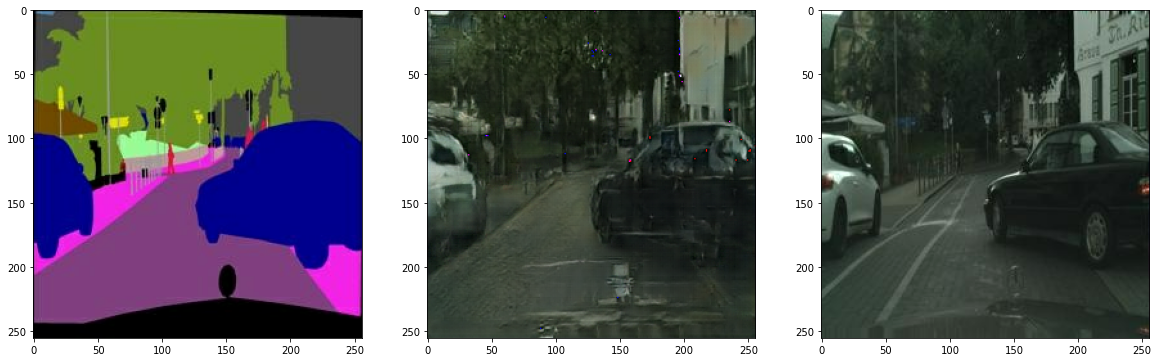

In [27]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [39]:
def show_predict(num_test=6):
    plt.figure(figsize=(25,30))
    for i in range(1,num_test+1):
        f = data_path + os.listdir(data_path)[i]
        sketch, colored = load_img(f)

        pred = generator(tf.expand_dims(sketch, 0))
        pred = denormalize(pred)

        
        plt.subplot(6,3,3*(i-1)+1);plt.imshow(denormalize(sketch))
        plt.subplot(6,3,3*(i-1)+2);plt.imshow(pred[0])
        plt.subplot(6,3,3*(i-1)+3);plt.imshow(denormalize(colored))

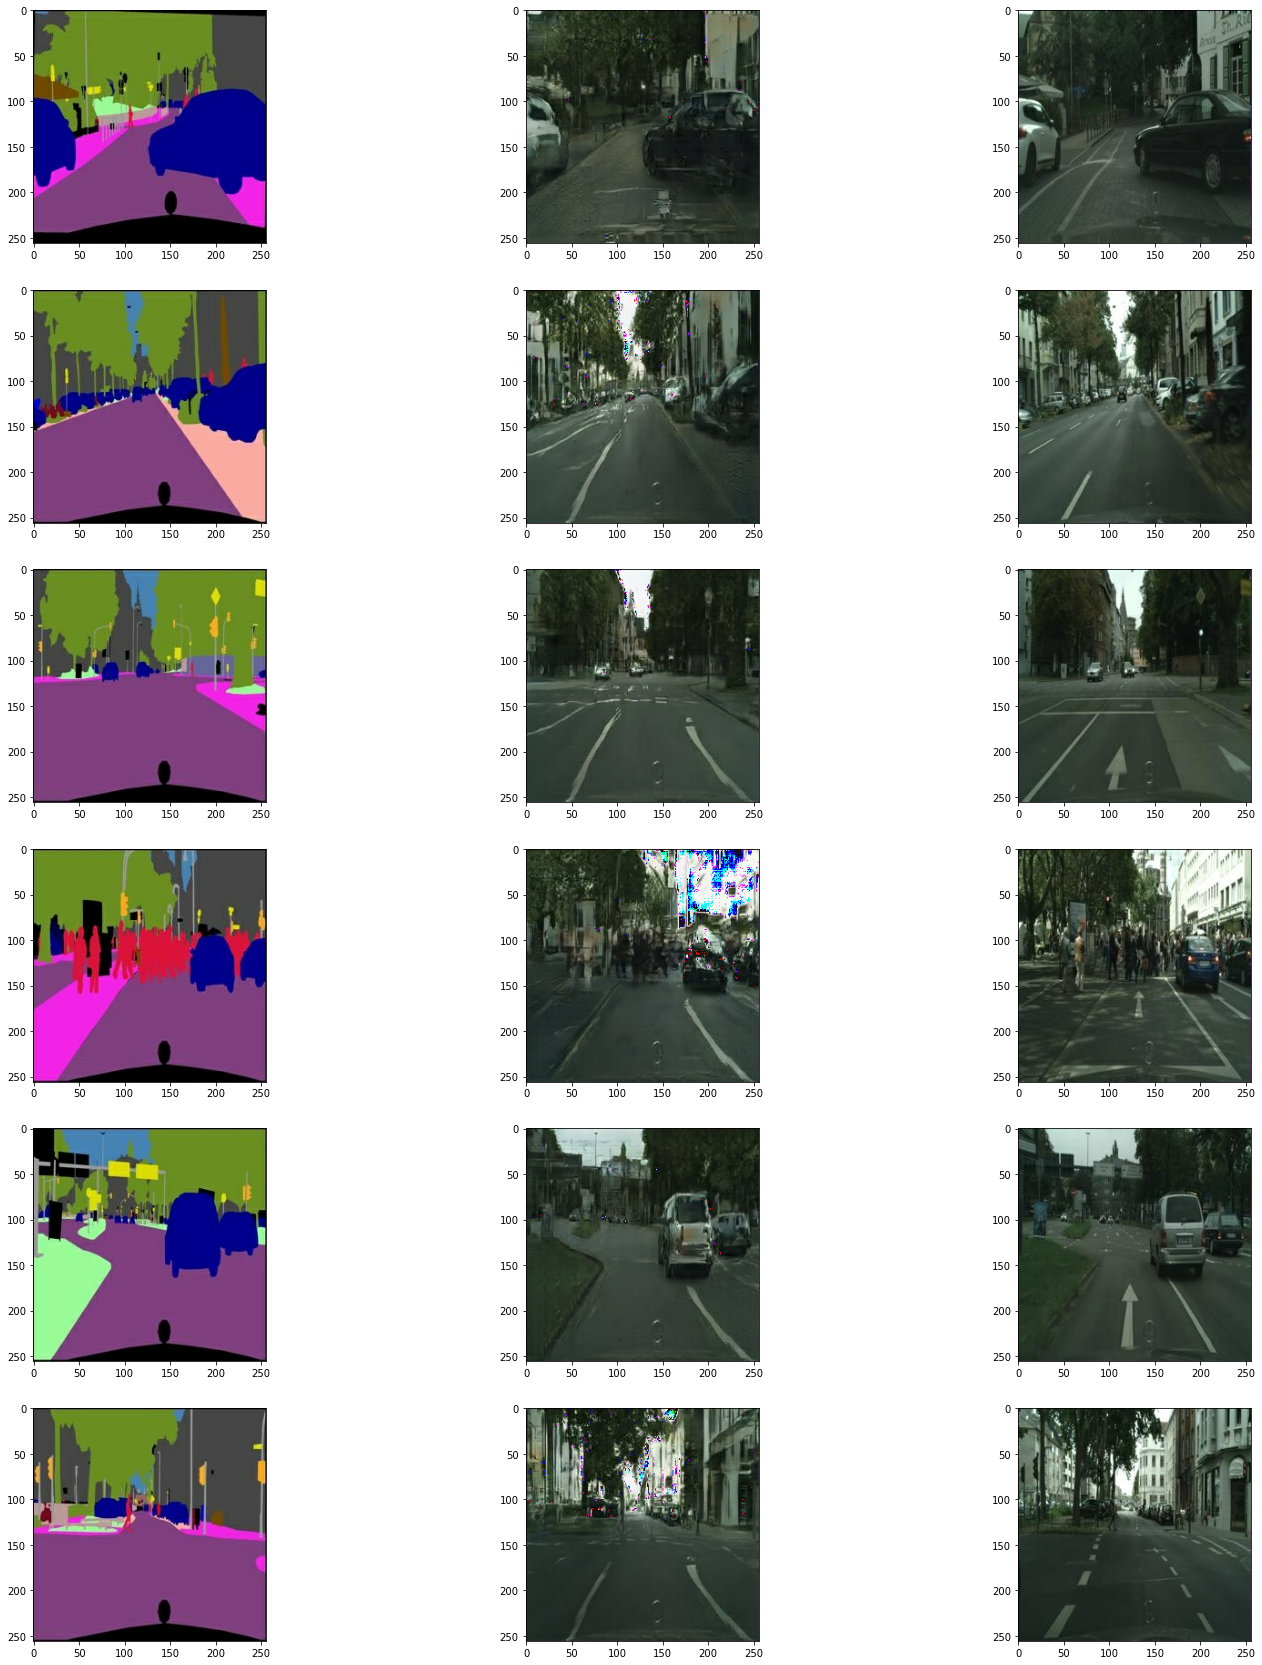

In [40]:
show_predict()